# Aprendizagem de máquina

### Anotações
- ω: varivel aleatoria
- P(ωk):probabilidade a priori de observar ωk
- p(x|ωj): funcao de densidade de probabilidade condicional de x dado que a classe é ωj
    - : p(x intersecção wj) / P(wj)
- P(ωj|x): probabilidade da classe ser ωj dado que observou-se x
    - : p(x|ωj)P(ωj)/p(x)

In [1]:
from math import ceil

import numpy as np
import pandas as pd
import itertools as it

# from scipy.stats import mode

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error

import scipy as sp
import scipy.stats as st

from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import colors

## Funções para os testes de Friedman e Nemenyi

In [2]:
def friedman_test(*args):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [sp.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/sp.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((sp.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    return iman_davenport, p_value, rankings_avg, rankings_cmp

def nemenyi_multitest(ranks):
    """
        Performs a Nemenyi post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of each pair of groups are different.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        Bonferroni-Dunn: O.J. Dunn, Multiple comparisons among means, Journal of the American Statistical Association 56 (1961) 52–64.
    """
    k = len(ranks)
    values = list(ranks.values())
#     print (ranks.keys())
    keys = list(ranks.keys())
    versus = list(it.combinations(range(k), 2))

    comparisons = [keys[vs[0]] + " vs " + keys[vs[1]] for vs in versus]
    z_values = [abs(values[vs[0]] - values[vs[1]]) for vs in versus]
    p_values = [2*(1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    m = int(k*(k-1)/2.)
    adj_p_values = [min(m*p_value,1) for p_value in p_values]
    
    return comparisons, z_values, p_values, adj_p_values


### Função para plotar os graficos de acuracias

In [4]:
def plot_accuracy(train, validation, all_data):
    
    fig, ax = plt.subplots()
    ax.plot(train, label='Treinamento')
    ax.plot(validation, label='Validação')
    ax.plot(all_data, label='Treinamento com toda a base de dados')
    ax.set(title='Acurácia do classificador', xlabel='Folds', ylabel='Acurácia')
    vals = ax.get_yticks()
    ax.set_yticklabels([('%.2f%%' % (x*100)) for x in vals])
    ax.legend()
    plt.show()

### Função para calcular o intervalo de confiânça

In [17]:
def confidence_interval(media, erro, tamanho_amostra, confianca = 1.96):
    
    """
    confiança
    1.64 (90%)
    1.96 (95%)
    2.33 (98%)
    2.58 (99%)
    """
    
#     err = confianca * pow((erro * (1 - erro))/tamanho_amostra, 0.5)
    err = confianca*
#     print (err)
    return [media - err, media + err, err]

# confidence_interval(0.85,0.09,2000)

## Leitura da base de dados

A leitura da base de dados foi feita utilizando a biblioteca `pandas`.

In [5]:
data_set = pd.read_csv('segmentation2.csv', skiprows=[0,1,2]) # skiprows utilizado para pular as 3 primeiras linhas do aquivo


## Alterando o nome da clase de string para número

In [6]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == 'GRASS') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 1 if (x == 'PATH') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 2 if (x == 'WINDOW') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 3 if (x == 'CEMENT') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 4 if (x == 'FOLIAGE') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 5 if (x == 'SKY') else x)
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 6 if (x == 'BRICKFACE') else x)

## Normalização e tratamento de repetições

In [7]:
columns = data_set.columns.tolist()
data_set.drop_duplicates(subset=columns, keep='first', inplace=True)  # Remove exemplos repetidos da base de dados

## Sepando a base em Kfolds

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os kfolds

In [8]:
def separar_grupos(data_set):
    grass = data_set[data_set.CLASS == 0]
    path = data_set[data_set.CLASS == 1]
    window = data_set[data_set.CLASS == 2]
    cement = data_set[data_set.CLASS == 3]
    foliage = data_set[data_set.CLASS == 4]
    sky = data_set[data_set.CLASS == 5]
    brickface = data_set[data_set.CLASS == 6]
    
    return [grass, path, window, cement, foliage, sky, brickface]
    

Criando função para, dado a base de dados separada por classes, dividi-la em kfolds, sendo que em cada fold tenha exatamente a mesma quantidade de exemplos de cada classe

In [9]:
def dividir_em_kfolds(grupos, numfolds = 10):
    
    def split_list(grupo, quant):
        grupos = []
        incremento = int(len(grupo)/quant)
        for g in range(0,len(grupo), incremento):
            grupos.append(grupo[g:g + incremento])
        return grupos[:quant]
    
    tam_grupo = 0
    for i, grupo in enumerate(grupos):
        grupos[i] = split_list(grupo, numfolds)
        tam_grupo = max(tam_grupo, len(grupos[i][0]))
    
    for i, grupo in enumerate(grupos):
        for j, g in enumerate(grupos[i]):
            grupos[i][j] = grupos[i][j].iloc[:,:].values
            if len(grupos[i][j]) < tam_grupo:
                grupos[i][j] = np.concatenate((grupos[i][j],grupos[i][j]), axis=0)
            grupos[i][j] = grupos[i][j][:tam_grupo]
            
    folds = []
    for i in range(0, numfolds):
        fold = np.concatenate((grupos[0][i], grupos[1][i],grupos[2][i],grupos[3][i],grupos[4][i],grupos[5][i],grupos[6][i]), axis=0)
        np.random.shuffle(fold)
        folds.append(fold)
                
    return folds
# for i in dividir_em_kfolds(separar_grupos(data_set)):
#     print (len(i))

Criando a função de dado os kfolds retornar os conjuntos de trainamento e validação e a função de dado os kfolds retornar uma lista com k conjuntos, sendo que em cada conjunto tem um conjunto de treinamento e um conjunto de validação

In [9]:
def kfolds(folds, i, k = 10):
    v = i%k
#     t = (i + 1)%k
#     validation = folds.pop(max(v,t))
    validation = folds.pop(v)
#     test = folds.pop(min(v,t))
    train = folds[0]
    for fold in folds[1:]:
        train = np.concatenate((train, fold), axis=0)
    
    return (train, validation)

def split(data, k = 300):
    folds = []
    for i in range(0,k):
        folds.append(kfolds(data[:], i))
    return folds
# grupos = dividir_em_grupos([grass, path, window, cement, foliage, sky, brickface])

## Dividindo a base em duas views

- `shape_view` é uma view com as primeiras 9 variáveis da base de dados, ou seja, tem as colunas `REGION-CENTROID-COL, REGION-CENTROID-ROW, REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5, SHORT-LINE-DENSITY-2, VEDGE-MEAN, VEDGE-SD, HEDGE-MEAN, HEDGE-SD, CLASS`
- `rgb_view` é uma view com as 10 ultimas variáveis da base de dados, ou seja, tem as colunas `INTENSITY-MEAN, RAWRED-MEAN, RAWBLUE-MEAN, RAWGREEN-MEAN, EXRED-MEAN, EXBLUE-MEAN, EXGREEN-MEAN, VALUE-MEAN, SATURATION-MEAN, HUE-MEAN, CLASS`

In [10]:
columns = data_set.columns.tolist()
shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
data_view = data_set.reindex(columns=columns[1:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence


## Utilizando o classificador bayesiano para fazer a classificação dos dados

Utilizando as 19 colunas da base de dados.
- Teve uma taxa média de 76,1429% de acerto
- Desvio padrão de ± 7,4088%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 80.0964%
Intervalo de confiânça: ± 0.0429%, com 95% de confiança!

Validação Kfolds:
Media: 78.8296%
Intervalo de confiânça: ± 0.1796%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 79.6740%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


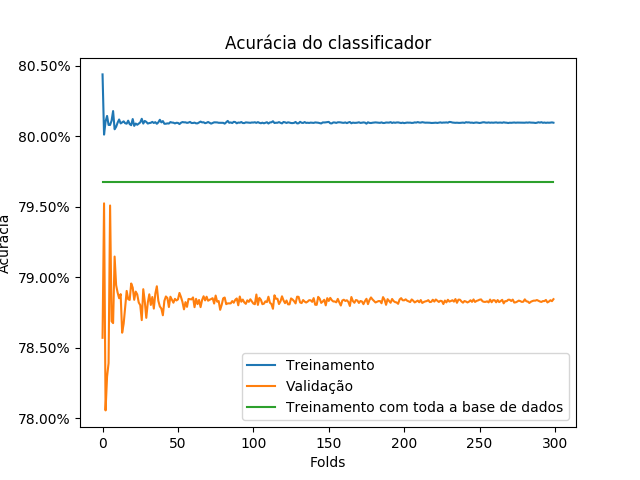

In [67]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0
# acuracia = []
for train, validation in kfolds.split(data_view.iloc[:,:-1].values, data_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()
    X_t = scaler.fit_transform(data_view.iloc[train,:-1].values)
    X_v = scaler.transform(data_view.iloc[validation,:-1].values)
    y_t = data_view.iloc[train,-1].values
    y_v = data_view.iloc[validation,-1].values
    gnb = GaussianNB(priors=priori)
    gnb.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = gnb.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = gnb.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    gnb.fit(X, y)
    pred = gnb.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )


    
print ()
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `shape_view` com as 9 primeiras colunas da base de dados.
- Teve uma taxa média de 45,8095% de acerto
- Desvio padrão de ± 3,2771%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 48.0915%
Intervalo de confiânça: ± 0.1443%, com 95% de confiança!

Validação Kfolds:
Media: 49.2984%
Intervalo de confiânça: ± 0.3192%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 48.5618%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


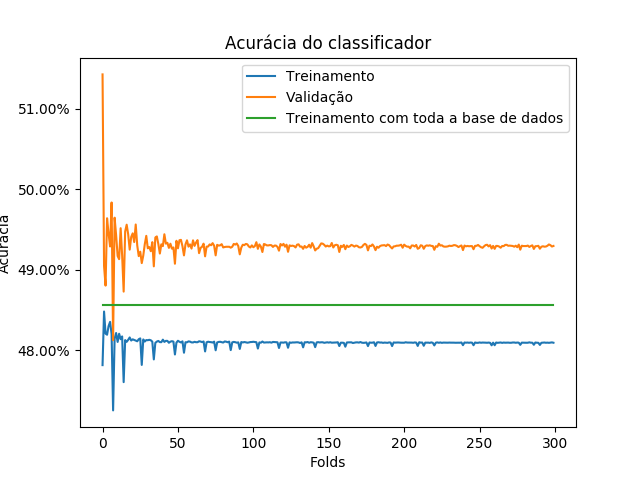

In [68]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

# folds = dividir_em_kfolds(separar_grupos(shape_view))
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(shape_view.iloc[:,:-1].values, shape_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()

    X_t = scaler.fit_transform(shape_view.iloc[train,:-1].values)
    X_v = scaler.transform(shape_view.iloc[validation,:-1].values)
    y_t = shape_view.iloc[train,-1].values
    y_v = shape_view.iloc[validation,-1].values
    gnb = GaussianNB(priors=priori)
    gnb.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = gnb.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = gnb.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    gnb.fit(X, y)
    pred = gnb.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

    
print ()    
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `rgb_view` com as 10 últimas colunas da base de dados.
- Taxa média de 73,8095% de acerto
- Desvio padrão de ± 8,0606, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 79.8076%
Intervalo de confiânça: ± 0.0242%, com 95% de confiança!

Validação Kfolds:
Media: 78.7064%
Intervalo de confiânça: ± 0.1429%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 79.9616%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


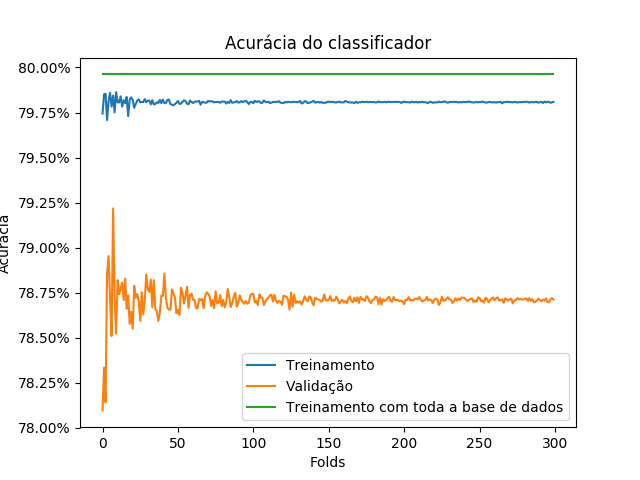

In [69]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

# folds = dividir_em_kfolds(separar_grupos(rgb_view))
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(rgb_view.iloc[:,:-1].values, rgb_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()

    X_t = scaler.fit_transform(rgb_view.iloc[train,:-1].values)
    X_v = scaler.transform(rgb_view.iloc[validation,:-1].values)
    y_t = rgb_view.iloc[train,-1].values
    y_v = rgb_view.iloc[validation,-1].values
    gnb = GaussianNB(priors=priori)
    gnb.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = gnb.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = gnb.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    gnb.fit(X, y)
    pred = gnb.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

    
print ()
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

## Utilizando o KNN para fazer a classificação dos dados

Utilizando as 19 colunas da base de dados.
- Foi testado valores para k entre 1 e 120
- O melhor resuldado se deu para k=1, que foi de 96,5441% de acerto
- Desvio padrão de ± 0,8676%, com o intervalo de confiança de 95%
- Para k=3, o classificador teve 95,9542% de acerto e desvio padrão de ± 0,9436%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 100.0000%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!

Validação Kfolds:
Media: 96.0810%
Intervalo de confiânça: ± 0.1813%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 100.0000%
Intervalo de confiânça: ± 0.0000%, com 95% de confiança!



<IPython.core.display.Javascript object>


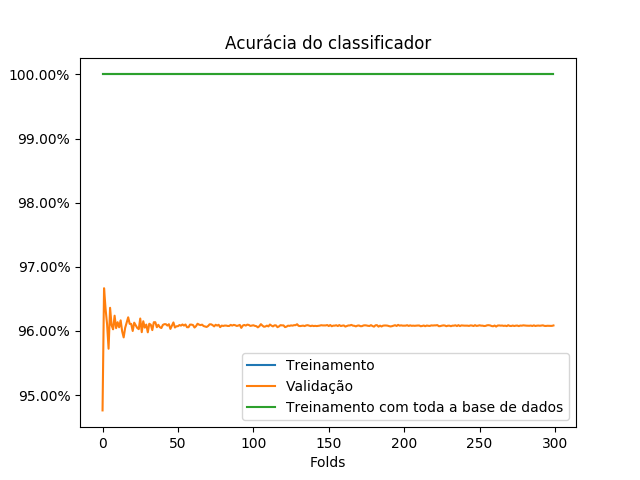

In [70]:
kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(data_view.iloc[:,:-1].values, data_view.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    
    scaler = StandardScaler()

    X_t = scaler.fit_transform(data_view.iloc[train,:-1].values)
    X_v = scaler.transform(data_view.iloc[validation,:-1].values)
    y_t = data_view.iloc[train,-1].values
    y_v = data_view.iloc[validation,-1].values

    knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    knn.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

    
print ()
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `shape_view` com as 9 primeiras colunas da base de dados.
- Foi testado valores para k entre 1 e 120
- O melhor resuldado se deu para k=6, que foi de 67,5679% de acerto
- Desvio padrão de ± 1,9552%, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 83.6193%
Intervalo de confiânça: ± 0.0288%, com 95% de confiança!

Validação Kfolds:
Media: 67.8888%
Intervalo de confiânça: ± 0.3773%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 84.0104%
Intervalo de confiânça: ± 0.0051%, com 95% de confiança!



<IPython.core.display.Javascript object>


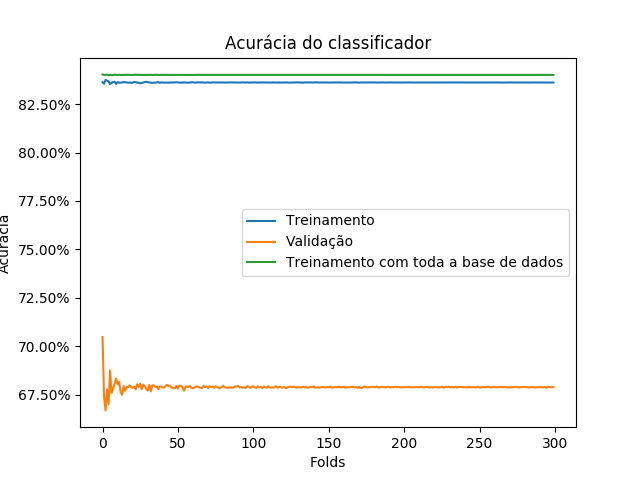

In [78]:
# folds = dividir_em_kfolds(separar_grupos(shape_view))

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(shape_view.iloc[:,:-1].values, shape_view.iloc[:,-1].values):

    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1

    scaler = StandardScaler()

    X_t = scaler.fit_transform(shape_view.iloc[train,:-1].values)
    X_v = scaler.transform(shape_view.iloc[validation,:-1].values)
    y_t = shape_view.iloc[train,-1].values
    y_v = shape_view.iloc[validation,-1].values

    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn.fit(X_t, y_t)

    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )

    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )

    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )


print ()

friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Utilizando a view `rgb_view` com as 10 últimas colunas da base de dados.
- Foi testado valores para k entre 1 e 120
- O melhor resuldado se deu para k=3, que foi de 90,2915% de acerto
- Desvio padrão de ± 1,4367, com o intervalo de confiança de 95%

99.67% [=================================================>]
Treinamento Kfolds:
Media: 94.6688%
Intervalo de confiânça: ± 0.0368%, com 95% de confiança!

Validação Kfolds:
Media: 89.9049%
Intervalo de confiânça: ± 0.1925%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 94.6766%
Intervalo de confiânça: ± 0.0197%, com 95% de confiança!



<IPython.core.display.Javascript object>


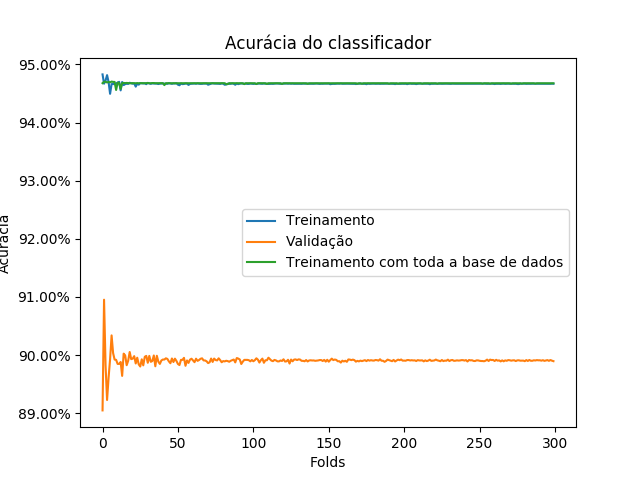

In [79]:
# folds = dividir_em_kfolds(separar_grupos(rgb_view))

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(rgb_view.iloc[:,:-1].values, rgb_view.iloc[:,-1].values):

    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1

    scaler = StandardScaler()

    X_t = scaler.fit_transform(rgb_view.iloc[train,:-1].values)
    X_v = scaler.transform(rgb_view.iloc[validation,:-1].values)
    y_t = rgb_view.iloc[train,-1].values
    y_v = rgb_view.iloc[validation,-1].values

    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn.fit(X_t, y_t)

    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )

    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )

    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )


print ()

friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

Retirando apenas as colunas 3,4 e 5 o classificador teve uma melhora de 0,52% em relação quando estava com todas as colunas, tendo assim uma taxa de acerto de 96,62% para k=1 e 95,81% para k=3

99.67% [=================================================>]
Treinamento Kfolds:
Media: 98.5465%
Intervalo de confiânça: ± 0.0169%, com 95% de confiança!

Validação Kfolds:
Media: 96.4279%
Intervalo de confiânça: ± 0.1155%, com 95% de confiança!

Treinamento com toda a base de dados:
Media: 98.5783%
Intervalo de confiânça: ± 0.0053%, com 95% de confiança!



<IPython.core.display.Javascript object>


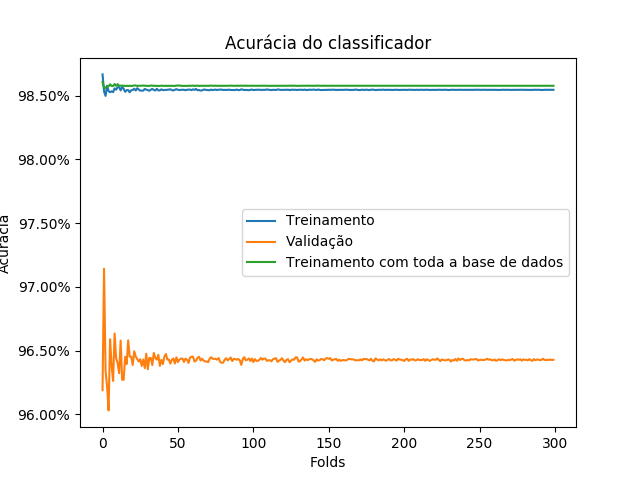

In [74]:
columns = data_set.columns.tolist()
data_set_mod = data_set.reindex(columns=columns[1:3] + columns[6:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence

kfolds = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=42)

acuracia_kfolds_train = []
acuracia_kfolds_validation = []
acuracia_all_train = []

progresso = 0

for train, validation in kfolds.split(data_set_mod.iloc[:,:-1].values, data_set_mod.iloc[:,-1].values):
    
    print ("\r%.2f%% [%s]" % (progresso/3,'='*int(progresso/6) + '>' + '-'*int(49-progresso/6)), end='')
    progresso += 1
    scaler = StandardScaler()

    X_t = scaler.fit_transform(data_set_mod.iloc[train,:-1].values)
    X_v = scaler.transform(data_set_mod.iloc[validation,:-1].values)
    y_t = data_set_mod.iloc[train,-1].values
    y_v = data_set_mod.iloc[validation,-1].values
    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn.fit(X_t, y_t)
    
    #acuracia kfolds
    #validation
    pred = knn.predict(X_v)
    acuracia_kfolds_validation.append((sum(acuracia_kfolds_validation) + accuracy_score(y_v, pred))/(len(acuracia_kfolds_validation) + 1) )
    
    #train
    pred = knn.predict(X_t)
    acuracia_kfolds_train.append((sum(acuracia_kfolds_train) + accuracy_score(y_t, pred))/(len(acuracia_kfolds_train) + 1) )
    
    #acuracia all train
    X = np.concatenate((X_t, X_v), axis=0)
    y = np.concatenate((y_t, y_v), axis=0)
    knn.fit(X, y)
    pred = knn.predict(X)
    acuracia_all_train.append((sum(acuracia_all_train) + accuracy_score(y, pred))/(len(acuracia_all_train) + 1) )

print ("")
friedman_gnb_shape = acuracia_kfolds_validation # utilizado para o teste de Friedman

# media das 3 medidas de acuracia
media_train = np.mean(acuracia_kfolds_train)
media_val = np.mean(acuracia_kfolds_validation)
media_all = np.mean(acuracia_all_train)

# intervalo de confiânça das 3 medidas de acuracia
intervalo_train = np.std(acuracia_kfolds_train, ddof=1)*1.96
intervalo_val = np.std(acuracia_kfolds_validation, ddof=1)*1.96
intervalo_all = np.std(acuracia_all_train, ddof=1)*1.96

print ("Treinamento Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_train*100, intervalo_train*100))
print ("Validação Kfolds:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_val*100, intervalo_val*100))
print ("Treinamento com toda a base de dados:\nMedia: %.4f%%\nIntervalo de confiânça: ± %.4f%%, com 95%% de confiança!\n" % (media_all*100, intervalo_all*100))

plot_accuracy(acuracia_kfolds_train, acuracia_kfolds_validation, acuracia_all_train)

In [65]:
# for i in range(0,20):
#     print 
from time import sleep
for i in range(0,95):
    print ("\r%.2f%% [%s]" % (i*100/95,'='*int(i/95) + '>' + '-'*int(49-i/95)), end='')
    sleep(0.1)

98.95% [>------------------------------------------------]

## Utilizando o voto majoritário para fazer a classificação dos dados

Para calcular o voto majoritário foi levado em consideração dois classificadores, o classificador bayesiano e o KNN, e para cada classificador foi utilizado duas views, a view `shape_view`e a `rgb_view`, assim totalizando 4 votos para cada caso de teste.

In [87]:
# probabilidade a priori das classes
priori = [1/7]*7
priori[0] += 1 - sum(priori)

folds = dividir_em_kfolds(separar_grupos(data_set))

acuracia = []
for (train, validation) in split(folds):
    scaler = StandardScaler()
    X_shape_t = scaler.fit_transform(train[:,1:10])
    X_shape_v = scaler.transform(validation[:,1:10])
    X_rgb_t = scaler.fit_transform(train[:,10:])
    X_rgb_v = scaler.transform(validation[:,10:])
    y_t = train[:,0]
    y_v = validation[:,0]
    
    knn_shape = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    knn_rgb = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    gnb_shape = GaussianNB(priors=priori)
    gnb_rgb = GaussianNB(priors=priori)
    
    knn_shape.fit(X_shape_t, y_t)
    knn_rgb.fit(X_rgb_t, y_t)
    gnb_shape.fit(X_shape_t, y_t)
    gnb_rgb.fit(X_rgb_t, y_t)
    
    pred_knn_shape = knn_shape.predict(X_shape_v)
    pred_knn_rgb = knn_rgb.predict(X_rgb_v)
    pred_gnb_shape = gnb_shape.predict(X_shape_v)
    pred_gnb_rgb = gnb_rgb.predict(X_rgb_v)
    
    pred = []
    for i in range(0, len(pred_knn_shape)):
        data = [pred_knn_shape[i], pred_knn_rgb[i], pred_gnb_shape[i], pred_gnb_rgb[i]]
        pred.append(st.mode(data).mode[0])
    acuracia.append(accuracy_score(y_v, pred))
friedman_voto = acuracia
media = sum(acuracia)/len(acuracia)
variancia = sum(list(map(lambda x: pow(x - media, 2), acuracia)))/len(acuracia)
desvio = pow(variancia,0.5)
intervalo = 2.262 * desvio/pow(10,0.5)
print ("media: %.4f%%\ndesvio: ± %.4f%%, com 95%% de confiança!" % (media*100, intervalo*100))

media: 82.4286%
desvio: ± 3.2078%, com 95% de confiança!


In [101]:
fri = friedman_test(friedman_gnb_shape, friedman_gnb_rgb, friedman_knn_shape, friedman_knn_rgb, friedman_voto)
print (fri[0])
print (fri[1])
print (fri[2])
print (fri[3])
dd = {
    "a": fri[3][0],
    "b": fri[3][1],
    "c": fri[3][2],
    "d": fri[3][3],
    "e": fri[3][4],
}
nem = nemenyi_multitest(dd)
print (nem[0])
print (nem[1])
print (nem[2])
print (nem[3])

3609.49673203
1.11022302463e-16
[1.0, 2.8500000000000001, 2.2999999999999998, 5.0, 3.8500000000000001]
[7.7459666924148349, 22.07600507338228, 17.815723392554119, 38.729833462074176, 29.821971765797112]
['a vs b', 'a vs c', 'a vs d', 'a vs e', 'b vs d', 'c vs d', 'c vs e', 'd vs e', 'b vs e', 'b vs c']
[14.330038380967444, 10.069756700139283, 30.98386676965934, 22.076005073382277, 16.653828388691895, 20.914110069520056, 12.006248373242993, 8.9078616962770631, 7.7459666924148323, 4.2602816808281609]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5479180117763462e-15, 2.0416942840384422e-05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5479180117763462e-14, 0.00020416942840384422]


In [69]:
from scipy.stats import friedmanchisquare

# print (len(friedman_gnb_shape))
# friedman = friedmanchisquare(friedman_gnb_shape, friedman_gnb_rgb, friedman_knn_shape, friedman_knn_rgb, friedman_voto)
# print (friedman)
print (len(friedman_gnb_rgb))
friedman = friedmanchisquare(friedman_gnb_rgb[:10], friedman_knn_shape[:10], friedman_voto[:10])
print (friedman)
# os 5 classificadores tem desempenho diferentes

300
FriedmanchisquareResult(statistic=12.666666666666661, pvalue=0.0017761035457343839)


In [166]:
from scipy.stats import friedmanchisquare

a = [5,3,6,4]
b = [2,3,8,1]
c = [1,8,5,3]

# a1 = [3,1.5,2,3]
# b1 = [2,1.5,3,1]
# c1 = [1,3,1,2]

# for i in range(0,len(friedman_voto)):
friedman = friedmanchisquare(a,b,c)
# friedman1 = friedmanchisquare(a1,b1,c1)
# print (dir(friedman))
print (friedman)
# print (friedman1)

FriedmanchisquareResult(statistic=0.93333333333333335, pvalue=0.62708908527305618)


In [148]:
#save in file
# data_set.to_csv("data.csv", index=False)
from scipy.stats import mode
d = [1.0,1.0,1.0,0.0,0.0,5.0]
e = [2,2,0,0,5,5]
# f = mode(e)
# print (f[0][0])
from collections import Counter
# a = [1,2,3,1,2,1,1,1,3,2,2,1]
b = Counter(d)
print (list(b.elements()))
print (b.most_common(1)[0][0])

[1.0, 1.0, 1.0, 0.0, 0.0, 5.0]
1.0


2100


<IPython.core.display.Javascript object>


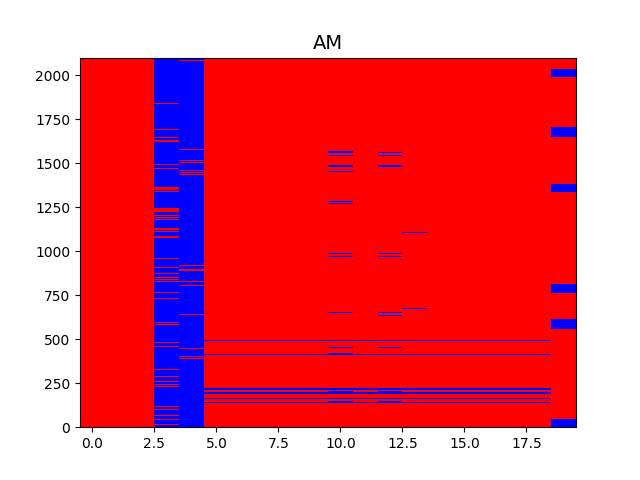

In [56]:
# grafico da base de dados
cmap = colors.ListedColormap(['blue', 'red'])
fig, axes = plt.subplots(nrows=1)
axes.set_title("AM", fontsize=14)
axes.axis([-0.5, 19.5, 0, 2100])
dados = data_set.iloc[:,:].values
# print (dados)
def t(x):
    def z(s):
#         print (s)
        return 0 if (s==0) else 1
#     print (x)
    return list(map(z, x))
dados = list(map(t, dados))
print (len(dados))
# for linha in dados:
#     l = []
#     for celula in linha[:-1]:
#         if celula == 0 or celula == None:
#             l.append(1)
#         else:
#             l.append(0)
#     if linha[-1] != 0 and linha[-1] != None:
#         l.append(0)
#     else:
#         l.append(1)
#     dadosPlot.append(tuple(l))
img = plt.imshow(dados, cmap=cmap, interpolation='nearest', aspect='auto')
plt.show()

In [95]:
#teste
# dados = data_set.iloc[:,:].values
# for j in range(0, len(dados[0])):
#     dif = []
#     for i in dados:
#         if i[j] not in dif:
#             dif.append(i[j])
#     print (len(dif))

a = np.array([[2,3,5],[6,3,2]])
a[1:,:]

array([[6, 3, 2]])

In [226]:
data_set = data_set.drop_duplicates(keep=False,inplace=False)  # Remove exemplos repetidos
# data_set

In [128]:
# Imprime as 5 primeiras linhas do data set
data_set.head(5)

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,CLASS
0,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,0
1,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,0
2,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,0
3,47.0,232.0,9,0.0,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,0
4,97.0,186.0,9,0.0,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,0


In [227]:
# Estatísticas sobre as variáveis
data_set.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,CLASS
count,2072.000000,2072.000000,2072.0,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2.072000e+03,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000
mean,124.667471,122.998552,9.0,0.015122,0.004612,1.893045,5.756815,2.382722,7.678556e+00,37.225082,32.959138,44.401384,34.314726,-12.797834,21.528904,-8.731070,45.368887,0.427818,3.007722
std,72.863107,57.572816,0.0,0.041263,0.023726,2.662145,45.289568,3.449985,5.356269e+01,38.300919,35.154412,43.691345,36.461680,11.613456,19.726051,11.664625,43.073206,0.228650,1.999019
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,0.000000
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.349603,0.819443,4.216376e-01,7.620370,7.111111,9.777778,6.333334,-18.694444,4.416667,-17.000000,11.888889,0.284859,1.000000
50%,121.000000,121.000000,9.0,0.000000,0.000000,1.222224,0.829630,1.444444,9.645273e-01,21.592592,19.666668,27.666667,20.333334,-10.888889,19.777779,-11.000000,28.666666,0.375666,3.000000
75%,188.000000,169.250000,9.0,0.000000,0.000000,2.222221,1.800201,2.555555,2.170293e+00,53.666668,47.694446,65.499998,46.805557,-4.305556,36.222220,-3.111111,65.499998,0.540634,5.000000
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,6.000000


Agora vamos separar o data set em atributos dependentes (X = features) e independentes (y = classe). No caso do `mammography` a classe majoritária está codificada como -1 e a classe minoritária está codificada como 1. Para treinar nossa rede neural precisamos que os valores de classe sejam 0 e 1 (restrição da biblioteca `keras`), assim modificamos a codificação da majoritária para 0.

Perceba que esse pré-processamento varia de data set para data set.

In [228]:
#separando os dados da classe de dados

grass = data_set[data_set.CLASS == 0]
path = data_set[data_set.CLASS == 1]
window = data_set[data_set.CLASS == 2]
cement = data_set[data_set.CLASS == 3]
foliage = data_set[data_set.CLASS == 4]
sky = data_set[data_set.CLASS == 5]
brickface = data_set[data_set.CLASS == 6]

In [229]:
# major_train, major_test = train_test_split(grass, test_size = 1/4, random_state = 42)
# print (type(major_train))

<class 'pandas.core.frame.DataFrame'>


In [272]:
# dividindo os dados em 10 folds com a mesma quantidade de exemplos em cada fold
def dividir_em_grupos(grupos, numfolds = 10):
    
    def split_list(grupo, quant):
        grupos = []
        incremento = int(len(grupo)/quant)
        for g in range(0,len(grupo), incremento):
            grupos.append(grupo[g:g + incremento])
        return grupos[:quant]
    
    tam_grupo = 0
    for i, grupo in enumerate(grupos):
        grupos[i] = split_list(grupo, numfolds)
        tam_grupo = max(tam_grupo, len(grupos[i][0]))
    
    for i, grupo in enumerate(grupos):
        for j, g in enumerate(grupos[i]):
            grupos[i][j] = grupos[i][j].iloc[:,:].values
            if len(grupos[i][j]) < tam_grupo:
                grupos[i][j] = np.concatenate((grupos[i][j],grupos[i][j]), axis=0)
            grupos[i][j] = grupos[i][j][:tam_grupo]
#             print (len(grupos[i][j]))
    folds = []
    for i in range(0, numfolds):
        fold = np.concatenate((grupos[0][i], grupos[1][i],grupos[2][i],grupos[3][i],grupos[4][i],grupos[5][i],grupos[6][i]), axis=0)
        np.random.shuffle(fold)
        folds.append(fold)
#         print (len(fold[i]))
                
    return folds
grupos = dividir_em_grupos([grass, path, window, cement, foliage, sky, brickface])
# print (grupos[0][0])

## Divisão dos Dados em Treino, Validação, e Teste

Aqui dividimos o data set em treino, validação e teste de maneira estratificada.

In [284]:
def kfolds(grupos, i, k = 10):
    v = i%k
    t = (i + 1)%k
    validation = grupos.pop(max(v,t))
    test = grupos.pop(min(v,t))
#     print (validation[0])
    train = grupos[0]
    for grupo in grupos[1:]:
        train = np.concatenate((train, grupo), axis=0)
    
    return (train, validation, test)

def split(data, k = 10):
    folds = []
    for i in range(0,k):
        folds.append(kfolds(data[:], i))
    return folds

from sklearn.naive_bayes import MultinomialNB

t,v,te = kfolds(grupos[:], 0)

# print (t)

for t,v,te in split(grupos):
    scaler = StandardScaler()
    t_i = t[:,-1]
    t_f = scaler.fit_transform(t[:,:-1])
    v_i = v[:,-1]
    v_f = scaler.transform(v[:,:-1])
    te_i = te[:,-1]
    te_f = scaler.transform(te[:,:-1])
    print (t[0])
    clf = MultinomialNB()
    clf.fit(t_f, t_i)
    print(clf.score(v_f, v_i))
    print (clf.score(te_f, te_i))
#     print (X[12:])
#     print(clf.predict(X[12:]))
#     print (len(t), len(v), len(te))

[  37.           25.            9.            0.            0.            1.3333321
    0.73029673    0.9999962     0.76011676  126.03704     114.333336
  142.22223     121.55556     -35.11111      48.555557    -13.444445
  142.22223       0.19609308    5.        ]


ValueError: Input X must be non-negative

## Sampling dos Dados e Normalização

Para testar o comportamento da rede com diferentes funções de sampling, as mesmas devem ser implementadas e aplicadas ao conjunto de treinamento antes da normalização dos dados (você também pode investigar qual o efeito de aplicar o sampling após a normalização).

In [7]:
## TO DO -- Implementar as funções de sampling a serem utilizadas

É importante lembrar de normalizar os dados. A classe `StandardScaler` centraliza as variáveis e transforma as features para terem variância unitária. Você pode testar outras opções como o `MinMaxScaler`.

Todas as alternativas estão disponíveis em:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing.

In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print (len(X_train))
print (len(X_val))

1036
518


## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [56]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(50, activation='relu', input_dim=19))

classifier.add(Dense(40, activation='relu',))

classifier.add(Dense(30, activation='relu',))

# classifier.add(Dense(30, activation='relu',))

classifier.add(Dense(15, activation='relu',))

classifier.add(Dense(8, activation='relu',))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='relu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=500,
                         validation_data=(X_val, y_val))                         
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 1036 samples, validate on 518 samples
Epoch 1/500
1036/1036 [==============================] - 0s - loss: 12.5037 - val_loss: 11.5107
Epoch 2/500
1036/1036 [==============================] - 0s - loss: 9.9457 - val_loss: 7.2888
Epoch 3/500
1036/1036 [==============================] - 0s - loss: 4.8837 - val_loss: 2.8726
Epoch 4/500
1036/1036 [==============================] - 0s - loss: 2.0576 - val_loss: 1.6245
Epoch 5/500
1036/1036 [==============================] - 0s - loss: 1.3973 - val_loss: 1.2734
Epoch 6/500
1036/1036 [==============================] - 0s - loss: 1.1338 - val_loss: 1.0383
Epoch 7/500
1036/1036 [==============================] - 0s - loss: 0.9388 - val_loss: 0.8827
Epoch 8/500
1036/1036 [==============================] - 0s - loss: 0.8095 - val_loss: 0.7552
Epoch 9/500
1036/1036 [==============================] - 0s - loss: 0.7152 - val_loss: 0.6922
Epoch 10/500
1036/1036 [==============================] - 0s - loss: 0.6415 - val_loss: 0.6011
Epoch 11/5

1036/1036 [==============================] - 0s - loss: 0.0278 - val_loss: 0.2555
Epoch 172/500
1036/1036 [==============================] - 0s - loss: 0.0292 - val_loss: 0.2197
Epoch 173/500
1036/1036 [==============================] - 0s - loss: 0.0356 - val_loss: 0.2537
Epoch 174/500
1036/1036 [==============================] - 0s - loss: 0.0337 - val_loss: 0.2376
Epoch 175/500
1036/1036 [==============================] - 0s - loss: 0.0286 - val_loss: 0.2517
Epoch 176/500
1036/1036 [==============================] - 0s - loss: 0.0309 - val_loss: 0.3273
Epoch 177/500
1036/1036 [==============================] - 0s - loss: 0.0414 - val_loss: 0.2341
Epoch 178/500
1036/1036 [==============================] - 0s - loss: 0.0386 - val_loss: 0.2524
Epoch 179/500
1036/1036 [==============================] - 0s - loss: 0.0288 - val_loss: 0.2663
Epoch 180/500
1036/1036 [==============================] - 0s - loss: 0.0300 - val_loss: 0.2751
Epoch 181/500
1036/1036 [=============================

1036/1036 [==============================] - 0s - loss: 0.0155 - val_loss: 0.2938
Epoch 342/500
1036/1036 [==============================] - 0s - loss: 0.0165 - val_loss: 0.2718
Epoch 343/500
1036/1036 [==============================] - 0s - loss: 0.0138 - val_loss: 0.2906
Epoch 344/500
1036/1036 [==============================] - 0s - loss: 0.0119 - val_loss: 0.2881
Epoch 345/500
1036/1036 [==============================] - 0s - loss: 0.0101 - val_loss: 0.2897
Epoch 346/500
1036/1036 [==============================] - 0s - loss: 0.0108 - val_loss: 0.2841
Epoch 347/500
1036/1036 [==============================] - 0s - loss: 0.0141 - val_loss: 0.2735
Epoch 348/500
1036/1036 [==============================] - 0s - loss: 0.0138 - val_loss: 0.2907
Epoch 349/500
1036/1036 [==============================] - 0s - loss: 0.0103 - val_loss: 0.2724
Epoch 350/500
1036/1036 [==============================] - 0s - loss: 0.0143 - val_loss: 0.2829
Epoch 351/500
1036/1036 [=============================

In [9]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(100, activation='relu', input_dim=6))

classifier.add(Dense(110, activation='relu',))

classifier.add(Dense(80, activation='relu',))

classifier.add(Dense(90, activation='relu',))

classifier.add(Dense(70, activation='relu',))

classifier.add(Dense(50, activation='relu',))

classifier.add(Dense(70, activation='relu',))

classifier.add(Dense(30, activation='relu',))

classifier.add(Dense(20, activation='relu',))

classifier.add(Dense(10, activation='relu',))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='relu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=150, 
                         callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 3922 samples, validate on 1961 samples
Epoch 1/150
3922/3922 [==============================] - 1s - loss: 0.0280 - val_loss: 0.0321
Epoch 2/150
3922/3922 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0321
Epoch 3/150
3922/3922 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0321
Epoch 4/150
3922/3922 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0321
Epoch 5/150
3922/3922 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0321
Epoch 6/150
3922/3922 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0321
Epoch 7/150
3922/3922 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0321


In [35]:
# treinando a rede utilizando os kfolds
histories = []
# for train_index, test_index in kfolds.split(data):
# for fold in grupos:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     print (len(X_test), len(X_train))
    histories.append(classifier.fit(X_train, y_train, batch_size=64, epochs=150, 
                             callbacks=[early_stopping], validation_data=(X_test, y_test)))

Train on 3922 samples, validate on 1961 samples
Epoch 1/150
3922/3922 [==============================] - 0s - loss: 0.0248 - val_loss: 0.0219
Epoch 2/150
3922/3922 [==============================] - 0s - loss: 0.0211 - val_loss: 0.0199
Epoch 3/150
3922/3922 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0202
Epoch 4/150
3922/3922 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0188
Epoch 5/150
3922/3922 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0193
Epoch 6/150
3922/3922 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0180
Epoch 7/150
3922/3922 [==============================] - 0s - loss: 0.0188 - val_loss: 0.0176
Epoch 8/150
3922/3922 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0178
Epoch 9/150
3922/3922 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0167
Epoch 10/150
3922/3922 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0175
Epoch 11/15

In [ ]:
#cross validation score
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=6, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print ("aqui")
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=10, verbose=0)
print (model)
print ("aqui 2")
kfold = StratifiedKFold(n_splits=10, shuffle=True)
print (kfold)
print ("aqui 3")
results = cross_val_score(model, X, y, cv=kfold)
print (results)
print ("aqui 4")
print(results.mean())

aqui
aqui 2
StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
aqui 3


In [10]:
#utilizado para salvar os pesos da rede
classifier.save_weights("pesos.h5", overwrite=True)

Algumas funções auxiliares.

In [53]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


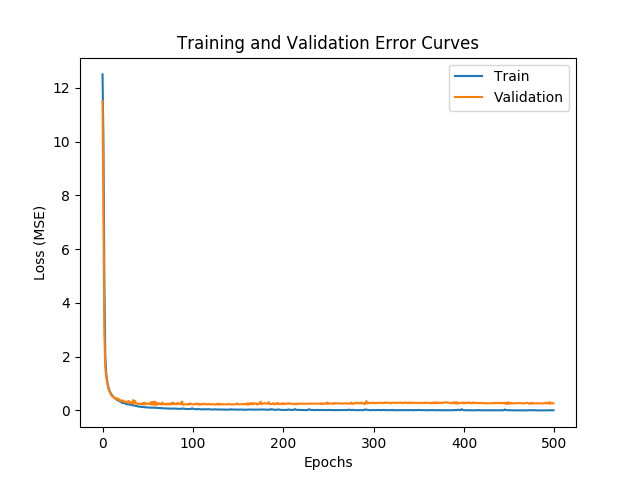

In [57]:
plot_training_error_curves(history)

<IPython.core.display.Javascript object>


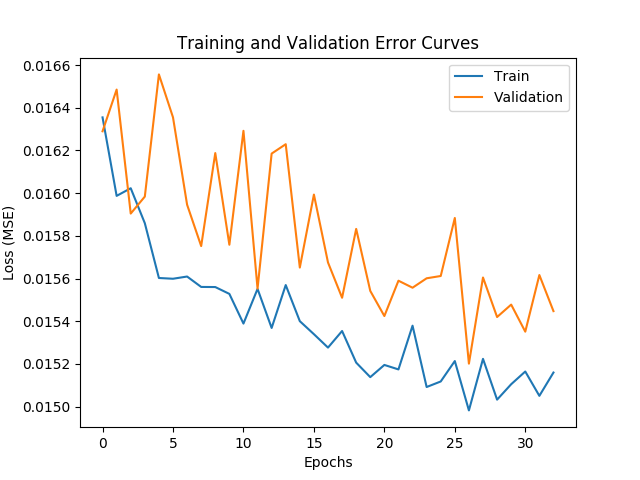

<IPython.core.display.Javascript object>


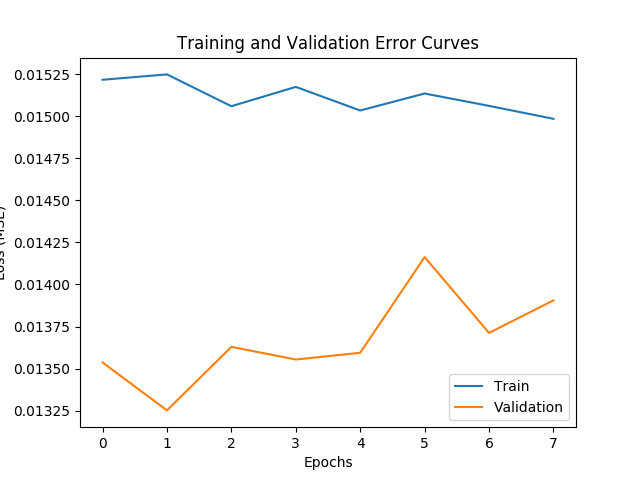

<IPython.core.display.Javascript object>


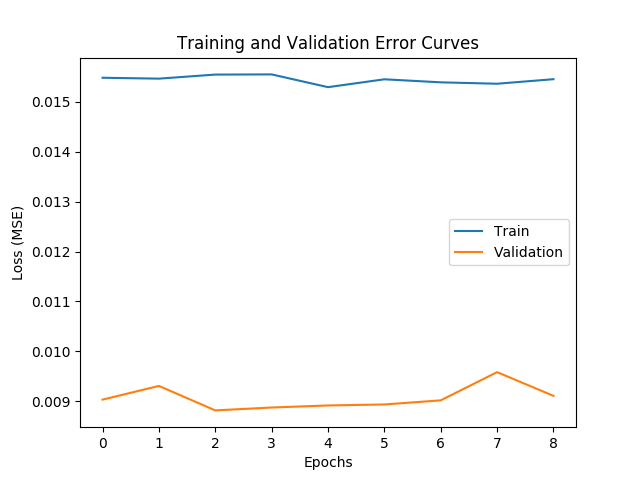

<IPython.core.display.Javascript object>


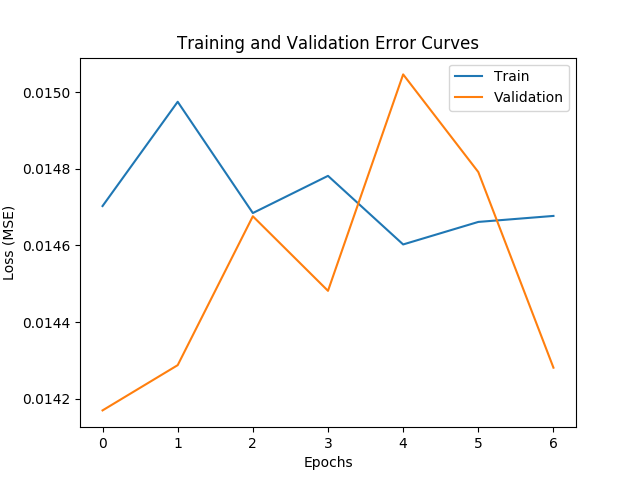

<IPython.core.display.Javascript object>


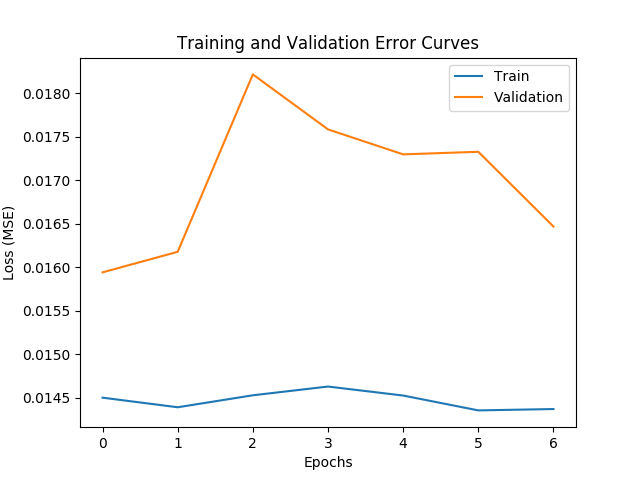

<IPython.core.display.Javascript object>


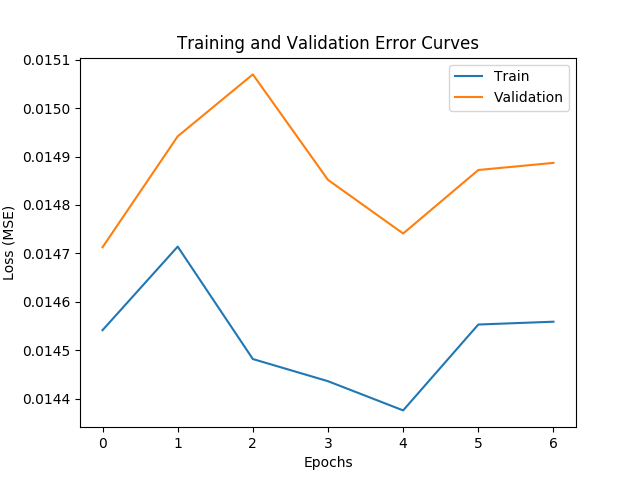

<IPython.core.display.Javascript object>


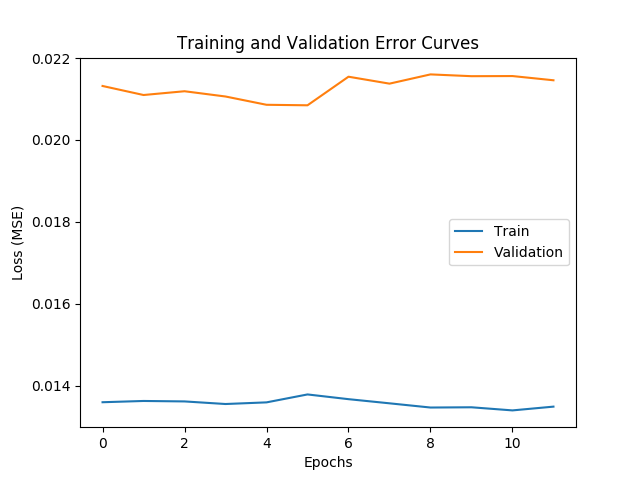

<IPython.core.display.Javascript object>


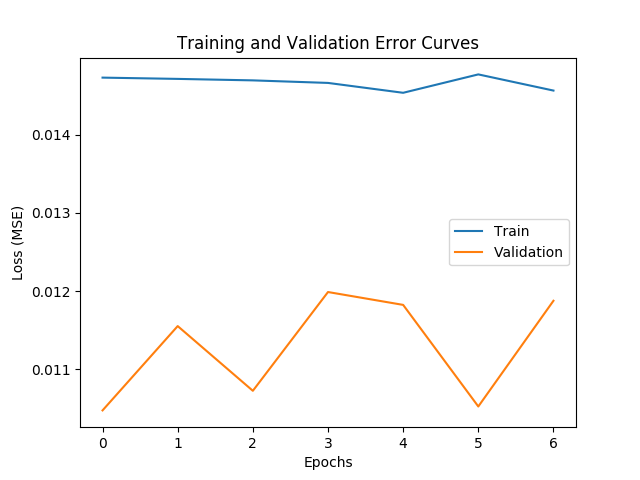

<IPython.core.display.Javascript object>


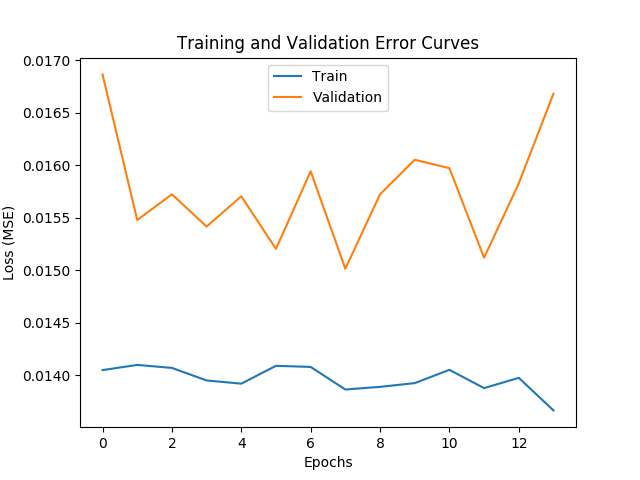

<IPython.core.display.Javascript object>


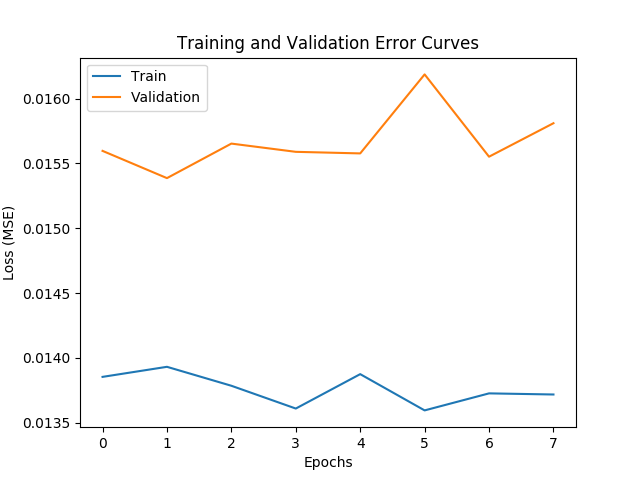

In [36]:
# plot k folds 
for h in histories:
    plot_training_error_curves(h)

In [38]:
# imprimindo a media e o desvio
historiesnp = []
for h in histories:
    historiesnp.append(h.history)
print("%.2f (+/- %.2f)" % (np.mean(historiesnp), np.std(historiesnp)))

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [19]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1891    8]
 [  28   35]]

Train Loss:       0.0134
Validation Loss:  0.0126
Accuracy:         0.9817
Recall:           0.5556
Precision:        0.8140
F1:               0.6604
AUROC:            0.8829
